# Compare a single track across time

In [1]:
import shapely as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
from math import sin, cos
pd.options.mode.chained_assignment = None

In [2]:
rgt, name = 1101, "gt3r"
header = f"{rgt}-{name}"
data_paths = [f"{header}/Bungen2021-01.json", f"{header}/Bungen2021-04.json", f"{header}/Bungen2021-07.json", f"{header}/Bungen2021-10.json"]
study_area_path = "Bounds/bungen.gpkg"
proj4_crs = "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

study_area = gpd.read_file(study_area_path)
study_area = study_area.to_crs(proj4_crs)
bounds = study_area["geometry"].total_bounds
xlim, ylim = (bounds[0], bounds[2]), (bounds[1], bounds[3])

In [3]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

In [4]:
data = []
for path in data_paths:
    print(f"Reading file: {path}", end= "\r")
    data.append(gpd.read_file(f"Saves/{path}"))

In [5]:
def cut_rgts(arr, filt):
    out = []
    for rgt in arr:
        if rgt in filt:
            out.append(rgt)
    return np.array(out)

rgts = np.unique(np.array(data[0]["rgt"]))
rgts = cut_rgts(rgts, np.unique(np.array(data[1]["rgt"])))
rgts = cut_rgts(rgts, np.unique(np.array(data[2]["rgt"])))
rgts = cut_rgts(rgts, np.unique(np.array(data[3]["rgt"])))
print(f"RGT's in all exports: \n{rgts}")

RGT's in all exports: 
[1101.]


In [6]:
def process_and_extract(data, rgt, name, gline_xy=gline_xy, describe = True, verbose=True):
    # extract data
    if describe:
        print(f"Extracting data     ", end="\r")
    single_beam = util.extract_data(data, rgt, name)
    
    # compute along track distance
    if describe:
        print(f"Comp along track dist    ", end="\r")
    single_beam = util.compute_along_track_dist(single_beam, verbose)
    
    # Hunt for intersect w/ gline
    if describe:
        print(f"Finding intersection    ", end="\r")
    single_beam, gline = util.find_gline_int(single_beam, gline_xy, verbose)
    
    # compute distance to the grounding line
    if describe:
        print(f"Computing gline dist    ", end="\r")
    single_beam = util.find_gline_dist(single_beam, gline)
    
    return single_beam

In [7]:
single_beams = []
i = 0
for dat in data:
    try:
        single_beams.append(process_and_extract(dat, rgt, name, verbose=False))
    except:
        print(f"Processing file {i + 1}")
    i += 1

In [8]:
order = 5
#cutoff = 0.065
cutoff = 0.032 # found by https://doi.org/10.5194/tc-14-3629-2020
print(f"Applying butterworth filter of order {5} with cutoff frequency of {cutoff}")
for i in range(len(single_beams)):
    single_beams[i]["slope-filt"] = util.apply_butter(single_beams[i]["slope"], order, cutoff)

Applying butterworth filter of order 5 with cutoff frequency of 0.032


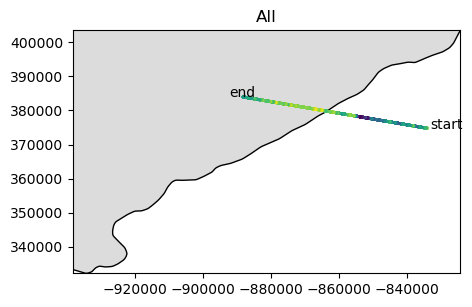

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

i = 0
for beam in single_beams:
    x, y = np.array(beam["x"]), np.array(beam["y"])
    ax.scatter(x, y, s=1, c = beam["slope-filt"])
    if i == 0:
        plt.text(x[0]+1e3,y[0], s="start")
        plt.text(x[-1]-4e3,y[-1], s="end")
    i += 1
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

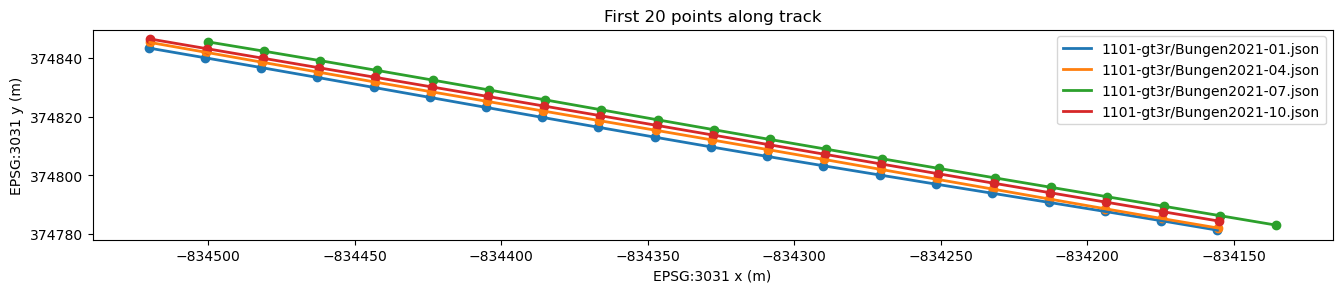

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
range_cnt = 20

i = 0
for beam in single_beams:
    x, y = np.array(beam["x"]), np.array(beam["y"])
    ax.scatter(x[:20], y[:20])
    ax.plot(x[:20], y[:20], label=data_paths[i], linewidth = 2)
    i += 1
    
ax.set_title("First 20 points along track")
ax.set_xlabel("EPSG:3031 x (m)")
ax.set_ylabel("EPSG:3031 y (m)")
ax.set_aspect('equal', adjustable='box')

plt.legend()
    
plt.show()

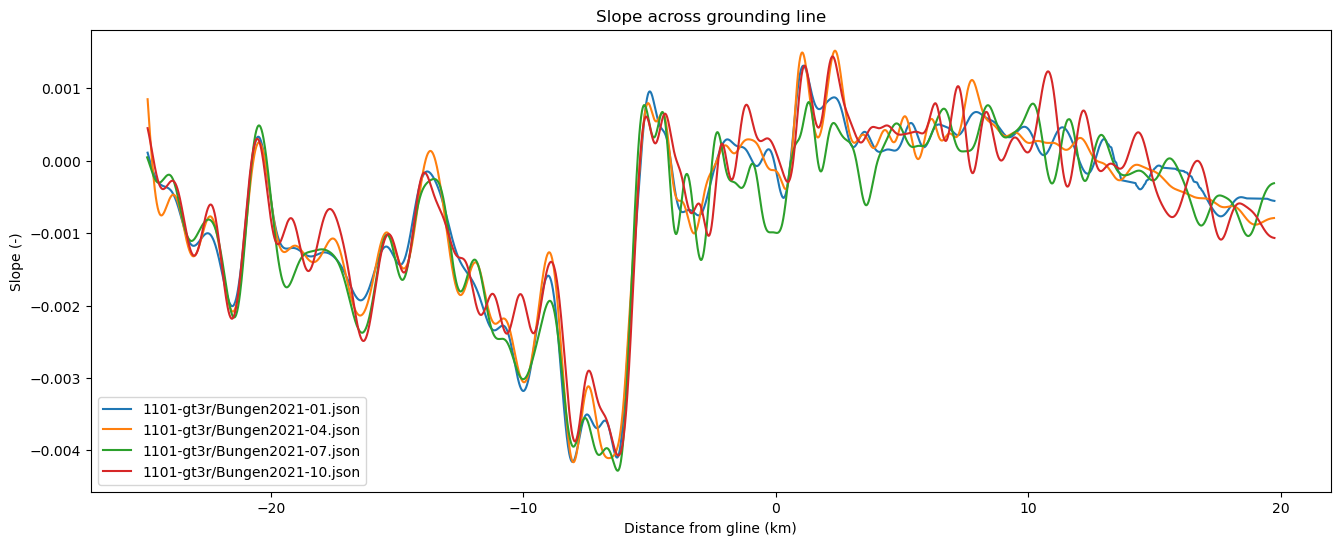

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (16, 6))

i = 0
for beam in single_beams:
    ax.plot(beam["gline_dist"],beam["slope-filt"], label=data_paths[i])
    #beam.plot(ax = ax[1], column="gline_dist", aspect = 1, markersize = 1)
    i += 1
    
ax.set_xlabel("Distance from gline (km)")
ax.set_ylabel("Slope (-)")
ax.set_title("Slope across grounding line")

plt.legend()
    
plt.show()

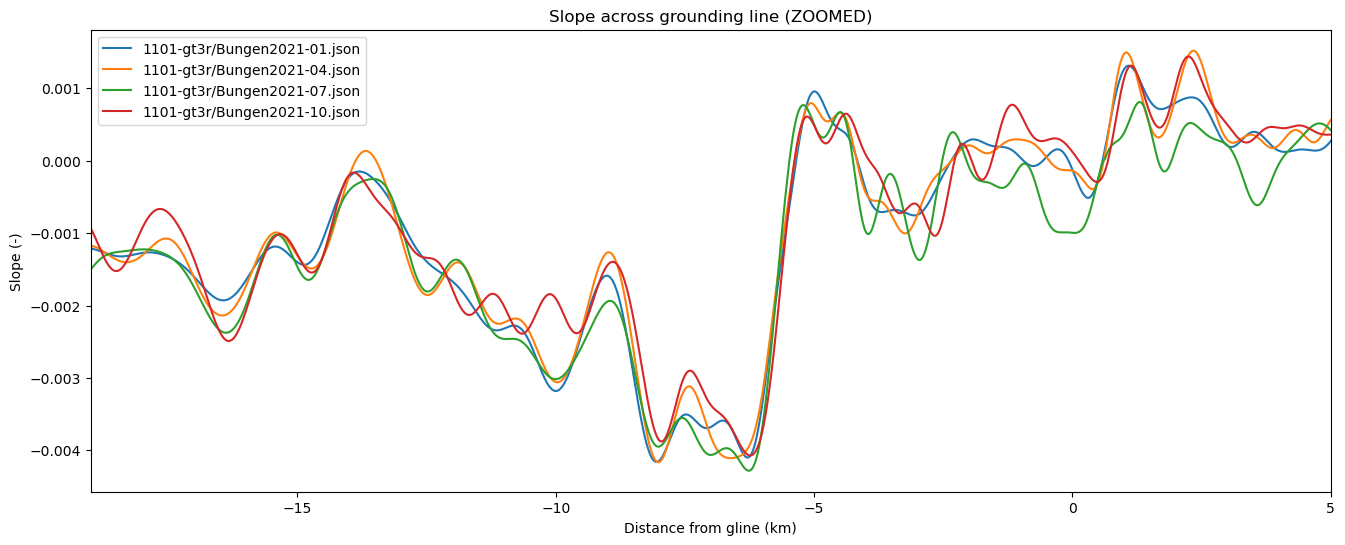

In [12]:
d_min = -19
d_max = 5

fig, ax = plt.subplots(1, 1, figsize = (16, 6))

i = 0
for beam in single_beams:
    ax.plot(beam["gline_dist"],beam["slope-filt"], label=data_paths[i])
    i += 1
    
ax.set_xlabel("Distance from gline (km)")
ax.set_ylabel("Slope (-)")
ax.set_title("Slope across grounding line (ZOOMED)")
ax.set_xlim(d_min, d_max)

plt.legend()
    
plt.show()

# Cross correlate

In [13]:
from scipy import signal

In [14]:
cropped = []
for beam in single_beams:
    cropped.append(beam[(beam["gline_dist"] > d_min) & (beam["gline_dist"] < d_max)])

### Visualize track proximity

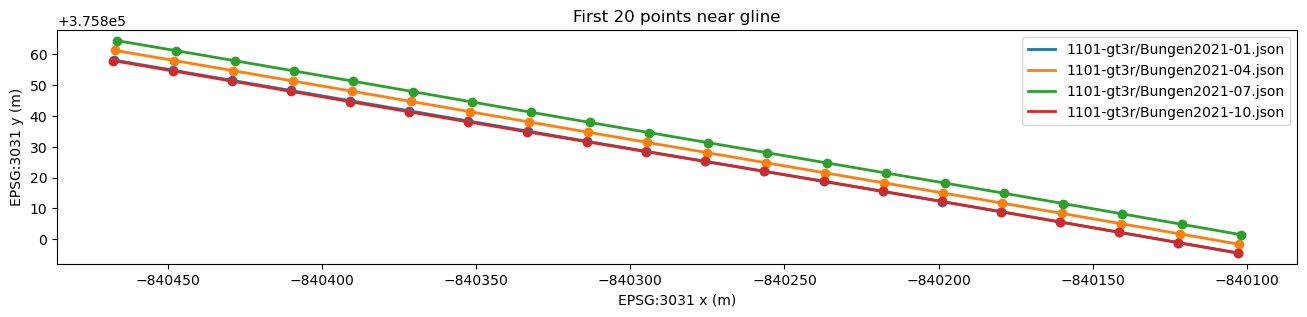

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
range_cnt = 20

i = 0
for crop in cropped:
    x, y = np.array(crop["x"]), np.array(crop["y"])
    ax.scatter(x[:20], y[:20])
    ax.plot(x[:20], y[:20], label=data_paths[i], linewidth = 2)
    i += 1
    
ax.set_title("First 20 points near gline")
ax.set_xlabel("EPSG:3031 x (m)")
ax.set_ylabel("EPSG:3031 y (m)")
ax.set_aspect('equal', adjustable='box')

plt.legend()
    
plt.show()

In [16]:
scaled = []
res_scale = 50
idx_x = np.linspace(cropped[0]["gline_dist"].min(), cropped[0]["gline_dist"].max(), num=len(cropped[0])*res_scale)
print(f"Transforming {len(cropped[0])} points into {len(cropped[0])*res_scale} points")
for crop in cropped:
    out = np.interp(idx_x, crop["gline_dist"], crop["slope-filt"])
    scaled.append(out)
    
final_lag = []
baseline = scaled[0]

for beam in scaled:
    correlation = signal.correlate(baseline, beam, mode="full")
    lags = signal.correlation_lags(len(baseline), len(beam), mode="full")
    final_lag.append(lags[np.argmax(correlation)])
    
print(f"Lags in terms of indices: {final_lag}")

d_dist = np.diff(idx_x)

med_delt_dist = np.median(np.array(d_dist))

lag_km = np.array(final_lag) * med_delt_dist

print(f"Lags in meters: {lag_km * 1000}")

i = 0
for crop in cropped:
    crop["gline_dist"] = crop["gline_dist"] + lag_km[i]
    i += 1

Transforming 1619 points into 80950 points
Lags in terms of indices: [0, 0, 0, -272]
Lags in meters: [  0.           0.           0.         -80.55888364]


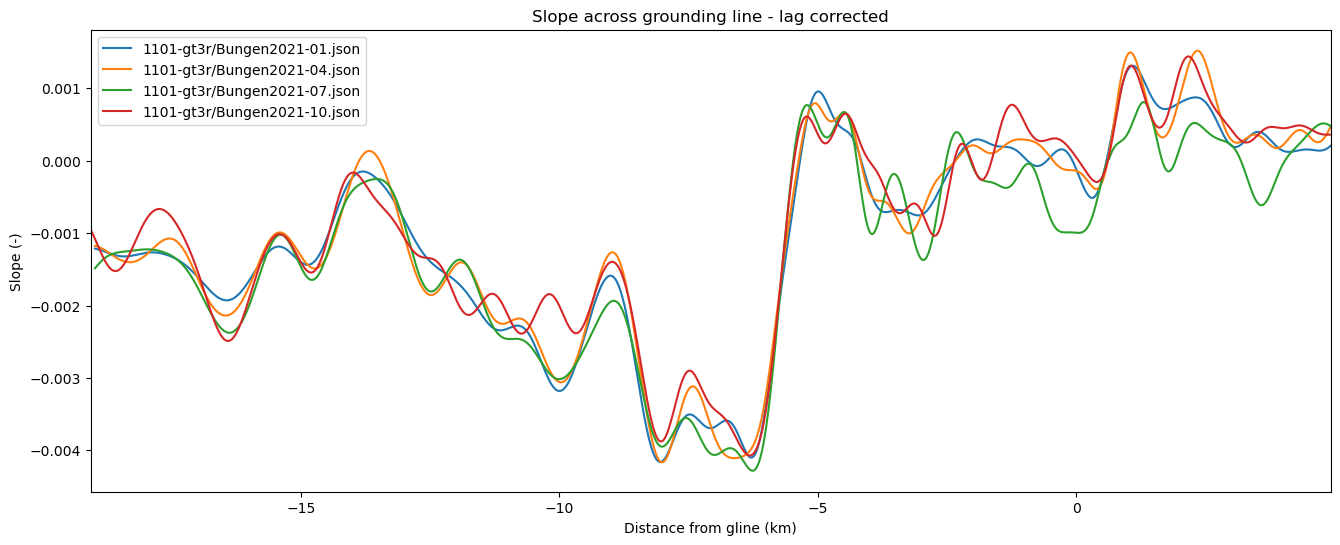

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (16, 6))

i = 0
for crop in cropped:
    ax.plot(crop["gline_dist"],crop["slope-filt"], label=data_paths[i])
    i += 1
    
ax.set_xlabel("Distance from gline (km)")
ax.set_ylabel("Slope (-)")
ax.set_title("Slope across grounding line - lag corrected")
ax.set_xlim(crop["gline_dist"].min(), crop["gline_dist"].max())

plt.legend()
    
plt.show()

# Derivative?

In [18]:
for crop in cropped:
    crop["gradient"] = np.gradient(crop["slope-filt"])

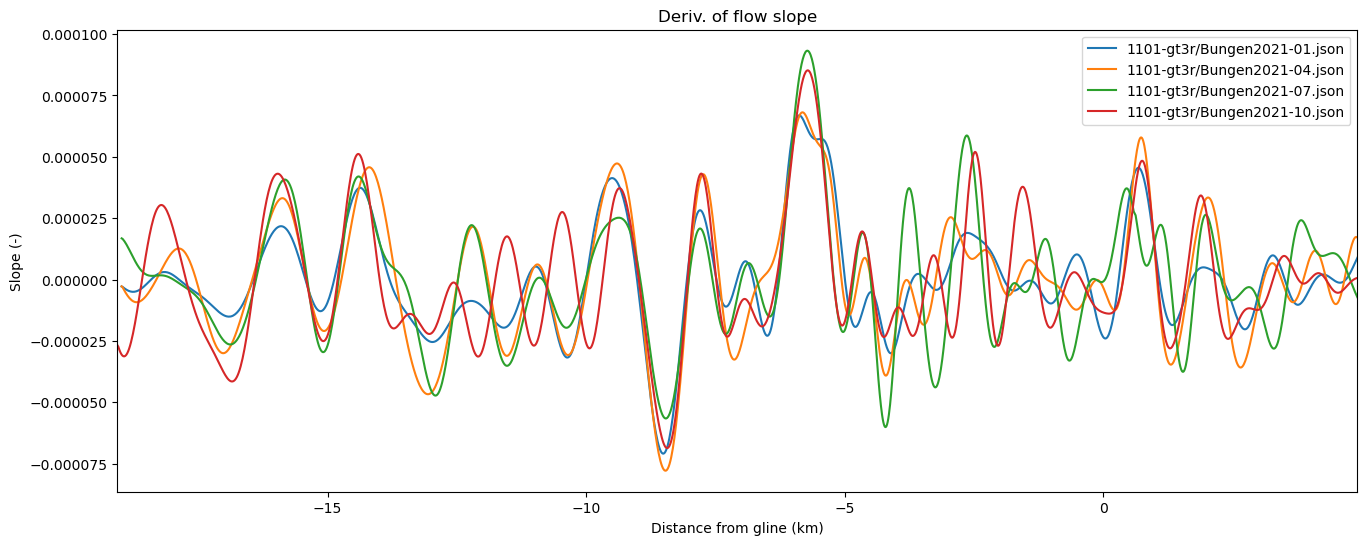

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (16, 6))

i = 0
for crop in cropped:
    ax.plot(crop["gline_dist"],crop["gradient"], label=data_paths[i])
    i += 1
    
ax.set_xlabel("Distance from gline (km)")
ax.set_ylabel("Slope (-)")
ax.set_title("Deriv. of flow slope")
ax.set_xlim(crop["gline_dist"].min(), crop["gline_dist"].max())

plt.legend()
    
plt.show()

Lags in terms of indices: [0, -1, 1, -7]
Lags in meters: [ 0.         -0.29617237  0.29617237 -2.07320656]


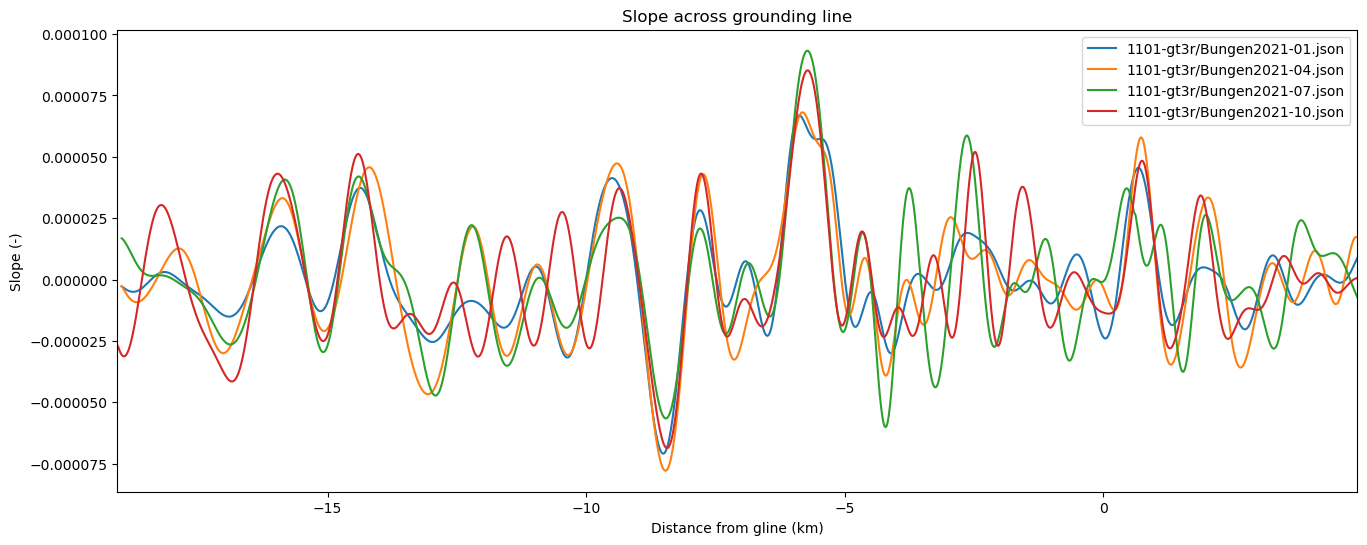

In [20]:
final_lag = []
baseline = cropped[0]["gradient"]

for crop in cropped:
    correlation = signal.correlate(baseline, crop["gradient"], mode="full")
    lags = signal.correlation_lags(len(baseline), len(crop["gradient"]), mode="full")
    final_lag.append(lags[np.argmax(correlation)])
    
print(f"Lags in terms of indices: {final_lag}")

d_dist = np.diff(idx_x)

med_delt_dist = np.median(np.array(d_dist))

lag_km = np.array(final_lag) * med_delt_dist

print(f"Lags in meters: {lag_km * 1000}")
    
fig, ax = plt.subplots(1, 1, figsize = (16, 6))

i = 0
for crop in cropped:
    ax.plot(crop["gline_dist"] + lag_km[i], crop["gradient"], label=data_paths[i])
    i += 1
    
ax.set_xlabel("Distance from gline (km)")
ax.set_ylabel("Slope (-)")
ax.set_title("Slope across grounding line")
ax.set_xlim(crop["gline_dist"].min(), crop["gline_dist"].max())

plt.legend()
    
plt.show()

# Assumed intersection location

In [21]:
# use linear interpolation of x and y based on dist from gline to calc int loc at dist = 0
idx_x = np.linspace(-0.1, 0.1, num=11)
print(idx_x)
xs, ys = [], []
for crop in cropped:
    x = np.interp(idx_x, crop["gline_dist"], crop["x"])
    xs.append(x)
    y = np.interp(idx_x, crop["gline_dist"], crop["y"])
    ys.append(y)

[-0.1  -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1 ]


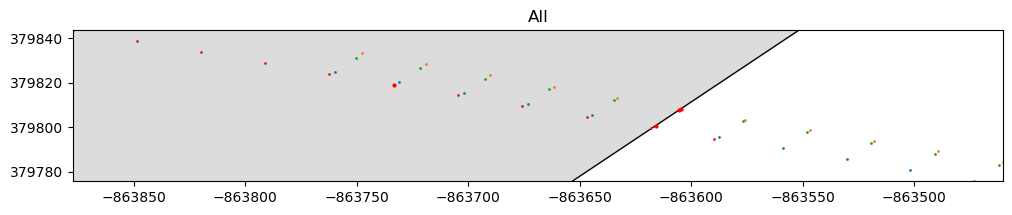

In [22]:
# THESE ARE NOT ACTUAL POINTS MEASURED, THEY ARE INTERPOLATED BASED
# ON DISTANCE FROM THE GROUNDING LINE
# THE POINTS BOLD AND IN RED ARE THE ONES SUPPOSEDLY AT A DISTANCE OF 0.
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

for i in range(len(xs)):
    ax.scatter(xs[i], ys[i], s=1)
    
for i in range(len(xs)):
    ax.scatter(xs[i][5], ys[i][5], s=4, c ="r")
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(np.array(xs).min(), np.array(xs).max())
plt.ylim(np.array(ys).min(), np.array(ys).max())
    
plt.show()

# Create a reference ground track

**First rotate track to change reference frame**

In [23]:
median_ang = 0
medians = []
for crop in cropped:
    medians.append(crop["azumith_in_xy"].median())
median_ang = sum(medians)/len(medians)
print(f"Median angle: {median_ang}")

Median angle: -0.16870456055760535


**Then rotate the track**

In [24]:
#for crop in cropped:
#    crop["geometry"] = crop["geometry"].rotate(-1 * median_ang, origin='center', use_radians=True)
#    crop["x"] = crop["x"]*cos(-1 * median_ang) - crop["y"]*sin(-1 * median_ang)
#    crop["y"] = crop["x"]*sin(-1 * median_ang) + crop["y"]*cos(-1 * median_ang)

In [25]:
min_len = min([len(crop) for crop in cropped])

x = []
y = []

for i in range(min_len):
    x.append(sum([crop["x"].iloc[i] for crop in cropped]) / len(cropped))
    y.append(sum([crop["y"].iloc[i] for crop in cropped]) / len(cropped))

**Visualize**

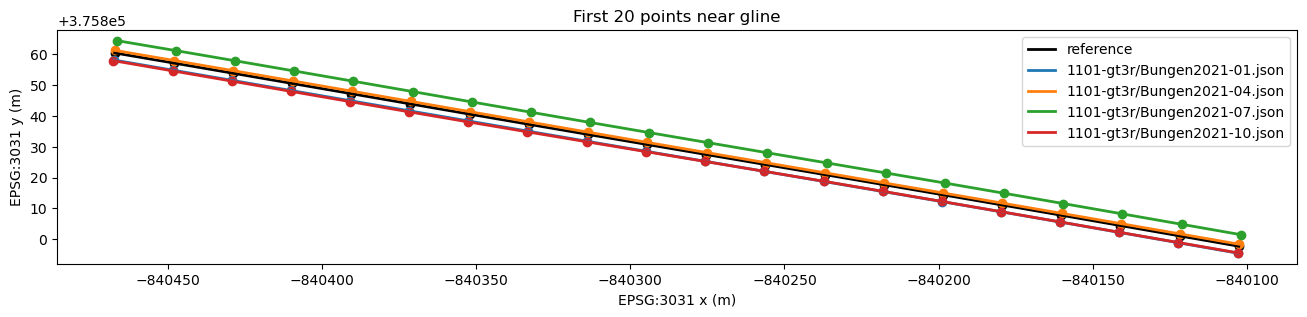

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
range_cnt = 20

ax.scatter(x[:20], y[:20], color="black")
ax.plot(x[:20], y[:20], label="reference", linewidth = 2, color="black")

i = 0
for crop in cropped:
    x, y = np.array(crop["x"]), np.array(crop["y"])
    ax.scatter(x[:20], y[:20])
    ax.plot(x[:20], y[:20], label=data_paths[i], linewidth = 2)
    i += 1
    
ax.set_title("First 20 points near gline")
ax.set_xlabel("EPSG:3031 x (m)")
ax.set_ylabel("EPSG:3031 y (m)")
ax.set_aspect('equal', adjustable='box')

plt.legend()
    
plt.show()